
==================== ATTACK SUMMARIES ====================
[ADDITIVE] Δ=14.36 L/min  days=2022-11-09..2022-11-12  hours=20:00–20:59, 21:00–21:59  affected=480 min
[DEDUCTIVE] Δ=28.77 L/min  days=2022-11-09..2022-11-12  hours=06:00–06:59, 07:00–07:59  affected=183 min

[Additive threshold] score_total >= nan  (calib first 5 days)
[Deductive threshold] score_total >= nan (calib first 5 days)

===== METRICS: Additive attacked dataset =====


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anacon

                  precision    recall  f1-score   support

 attack_additive      0.000     0.000     0.000       480
attack_deductive      0.000     0.000     0.000         0
 benign_activity      1.000     1.000     1.000       126
          normal      0.990     1.000     0.995     46267

       micro avg      0.990     0.990     0.990     46873
       macro avg      0.497     0.500     0.499     46873
    weighted avg      0.980     0.990     0.985     46873

Confusion Matrix (labels order): ['attack_additive', 'attack_deductive', 'benign_activity', 'normal']
[[    0     0     0   480]
 [    0     0     0     0]
 [    0     0   126     0]
 [    0     0     0 46267]]

===== METRICS: Deductive attacked dataset =====


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anacon

                  precision    recall  f1-score   support

 attack_additive      0.000     0.000     0.000         0
attack_deductive      0.000     0.000     0.000       183
 benign_activity      1.000     1.000     1.000       143
          normal      0.996     1.000     0.998     46547

       micro avg      0.996     0.996     0.996     46873
       macro avg      0.499     0.500     0.500     46873
    weighted avg      0.992     0.996     0.994     46873

Confusion Matrix (labels order): ['attack_additive', 'attack_deductive', 'benign_activity', 'normal']
[[    0     0     0     0]
 [    0     0     0   183]
 [    0     0   143     0]
 [    0     0     0 46547]]


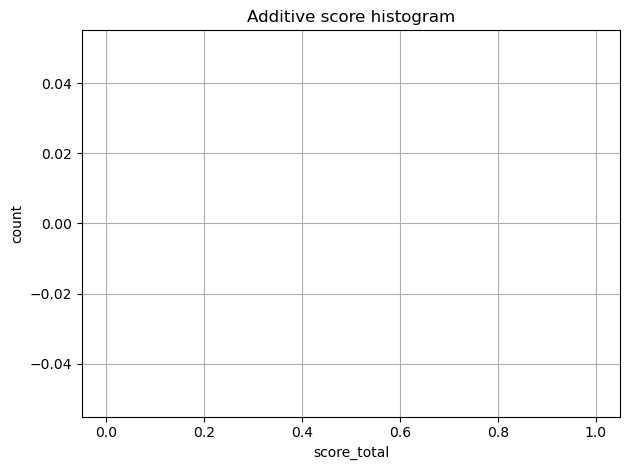

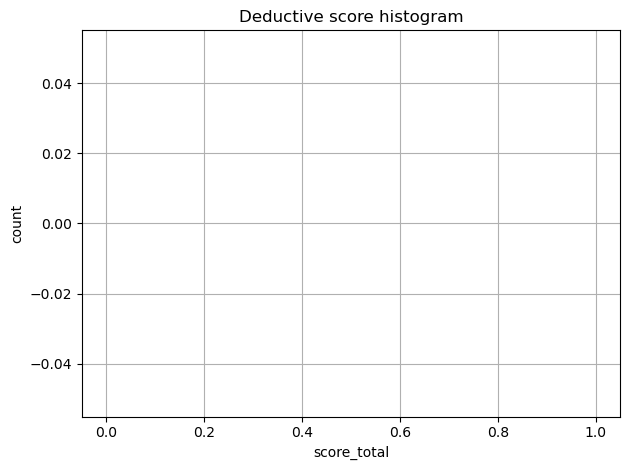


Saved files:
 - Attacked (additive): combined_minute_ALL_additive_attacked_labeled.csv
 - Attacked (deductive): combined_minute_ALL_deductive_attacked_labeled.csv
 - Scored  (additive): combined_minute_ALL_additive_attacked_labeled_scored.csv
 - Scored  (deductive): combined_minute_ALL_deductive_attacked_labeled_scored.csv


In [2]:
# %% [markdown]
# # Household Water Usage: Attack Injection + Detection (Your Rule-Based Idea)
# - Injects ONE additive and ONE deductive attack.
# - Detection = same hour vs previous days + same hour vs previous weeks + immediate past pattern.
# - Classifies: attack_additive / attack_deductive / benign_activity / normal.
# - Prints metrics and saves outputs.

# %%
import os
import math
import random
from collections import deque
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ------------- CONFIG -------------
INPUT_CSV = "combined_minute_ALL.csv"  # change if needed
OUT_ADD_ATTACKED = "combined_minute_ALL_additive_attacked_labeled.csv"
OUT_DED_ATTACKED = "combined_minute_ALL_deductive_attacked_labeled.csv"
OUT_ADD_SCORED   = "combined_minute_ALL_additive_attacked_labeled_scored.csv"
OUT_DED_SCORED   = "combined_minute_ALL_deductive_attacked_labeled_scored.csv"

CFG = {
    # Attack injection
    "RANDOM_SEED": 42,
    "DELTA_MIN": 5.0,     # L/min
    "DELTA_MAX": 30.0,    # L/min
    "DURATION_HOURS": 2,  # consecutive hours per attacked day
    "WINDOW_DAYS": 4,     # consecutive days
    "HIGH_USAGE_HOURS": list(range(6,10)) + list(range(18,22)),  # for deductive
    "USAGE_EPSILON": 1e-6,

    # Detection idea params
    "CALIB_DAYS": 5,      # use first N days to fit threshold
    "PAST_HOURS": 2,      # persistence window (hours)
    "W_DAY": 1.0,
    "W_WEEK": 1.0,
    "W_PATTERN": 1.0,
    "TARGET_Q": 0.995,    # threshold quantile on score_total
    "N_HISTORY": 200,     # cap history per (hour)/(dow,hour)
}

random.seed(CFG["RANDOM_SEED"])
np.random.seed(CFG["RANDOM_SEED"])

# ------------- Utilities -------------
def autodetect_columns(df: pd.DataFrame,
                       ts_hint: Optional[str] = None,
                       liters_hint: Optional[str] = None,
                       m3_hint: Optional[str] = None) -> Tuple[str, str]:
    """Return (timestamp_col, liters_col). If only m3 exists, create liters."""
    ts_col = ts_hint
    if ts_col is None:
        cands = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
        if not cands:
            for c in df.columns:
                try:
                    pd.to_datetime(df[c])
                    cands = [c]; break
                except Exception:
                    continue
        if not cands:
            raise ValueError("Could not auto-detect timestamp column. Set ts_hint.")
        ts_col = cands[0]
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    if df[ts_col].isna().all():
        raise ValueError(f"Timestamp column '{ts_col}' not parseable.")

    liters_col = liters_hint if (liters_hint and liters_hint in df.columns) else None
    m3_col = m3_hint if (m3_hint and m3_hint in df.columns) else None

    if liters_col is None:
        for c in df.columns:
            if "liter" in c.lower():
                liters_col = c; break

    if liters_col is None:
        if m3_col is None:
            for c in df.columns:
                cl = c.lower()
                if "m3" in cl or "m^3" in cl or "m³" in cl or cl.endswith("_m3") or cl.startswith("m3"):
                    m3_col = c; break
        if m3_col is not None:
            df["liters"] = pd.to_numeric(df[m3_col], errors="coerce").astype(float) * 1000.0
            liters_col = "liters"
        else:
            # fallback: highest-variance numeric column
            num = df.select_dtypes(include=[np.number]).columns.tolist()
            if not num: raise ValueError("No numeric column for consumption.")
            liters_col = df[num].var().sort_values(ascending=False).index[0]
    df[liters_col] = pd.to_numeric(df[liters_col], errors="coerce").astype(float)
    return ts_col, liters_col

def choose_four_day_window(dates: List[pd.Timestamp], window_days: int) -> pd.Timestamp:
    uniq = sorted(pd.to_datetime(pd.Series(dates).dt.floor("D")).dropna().unique())
    if len(uniq) < window_days:
        raise ValueError(f"Need at least {window_days} unique days.")
    for i in range(len(uniq)-window_days+1):
        if all((uniq[i+k+1]-uniq[i+k]).days == 1 for k in range(window_days-1)):
            return uniq[i]
    return uniq[0]

def pick_hour_block(candidate_hours: List[int], block_len: int) -> List[int]:
    candidate_hours = sorted(set(candidate_hours))
    if block_len <= 1:
        return [random.choice(candidate_hours)]
    runs, run = [], [candidate_hours[0]]
    for h in candidate_hours[1:]:
        if h == run[-1] + 1: run.append(h)
        else: runs.append(run); run=[h]
    runs.append(run)
    blocks = []
    for r in runs:
        if len(r) >= block_len:
            for i in range(len(r)-block_len+1):
                blocks.append(r[i:i+block_len])
    if not blocks:
        return sorted(random.sample(candidate_hours, min(block_len, len(candidate_hours))))
    return random.choice(blocks)

def inject_attack(df: pd.DataFrame, ts_col: str, liters_col: str, attack_type: str, cfg=CFG):
    dfa = df.copy().sort_values(ts_col).reset_index(drop=True)
    dfa["date"] = dfa[ts_col].dt.floor("D")
    dfa["hour"] = dfa[ts_col].dt.hour

    start_day = choose_four_day_window(dfa["date"].tolist(), cfg["WINDOW_DAYS"])
    days = [start_day + pd.Timedelta(days=k) for k in range(cfg["WINDOW_DAYS"])]

    if attack_type == "additive":
        attack_hours = pick_hour_block(list(range(24)), cfg["DURATION_HOURS"])
    elif attack_type == "deductive":
        attack_hours = pick_hour_block(cfg["HIGH_USAGE_HOURS"], cfg["DURATION_HOURS"])
        if not attack_hours:
            raise ValueError("No valid hour-block within HIGH_USAGE_HOURS.")
    else:
        raise ValueError("attack_type must be 'additive' or 'deductive'.")

    delta = round(float(np.random.uniform(cfg["DELTA_MIN"], cfg["DELTA_MAX"])), 2)
    dfa["attack_flag"] = 0
    affected = 0
    for d in days:
        mask = (dfa["date"].eq(d)) & (dfa["hour"].isin(attack_hours))
        if attack_type == "deductive":
            mask &= (dfa[liters_col] > cfg["USAGE_EPSILON"])
        dfa.loc[mask, "attack_flag"] = 1
        affected += int(mask.sum())
    if affected == 0:
        raise RuntimeError(f"No minutes matched the attack mask for {attack_type}.")

    dfa["liters_before"] = dfa[liters_col].astype(float)
    if attack_type == "additive":
        dfa["liters_after"] = dfa["liters_before"] + dfa["attack_flag"]*delta
    else:
        dfa["liters_after"] = dfa["liters_before"] - dfa["attack_flag"]*delta
        dfa.loc[dfa["liters_after"] < 0, "liters_after"] = 0.0

    dfa["y"] = dfa["liters_after"]  # observed series under attack
    hrs_human = ", ".join([f"{h:02d}:00–{h:02d}:59" for h in attack_hours])
    summary = {
        "attack_type": attack_type,
        "delta_L_per_min": delta,
        "window_days": cfg["WINDOW_DAYS"],
        "days": [pd.Timestamp(d).strftime("%Y-%m-%d") for d in days],
        "hours": attack_hours, "hours_human": hrs_human,
        "affected_minutes": affected, "total_minutes": int(dfa.shape[0])
    }
    return dfa, summary

def find_col(df: pd.DataFrame, keys: List[str]) -> Optional[str]:
    low = {c.lower(): c for c in df.columns}
    for k in keys:
        for lk, orig in low.items():
            if k in lk:
                return orig
    return None

# ------------- Detection (your 3-part score) -------------
def compute_scores_fast(df: pd.DataFrame, ts_col: str):
    df = df.copy()
    df["date"] = df[ts_col].dt.floor("D")
    df["hour"] = df[ts_col].dt.hour
    df["dow"]  = df[ts_col].dt.dayofweek

    y = df["y"].values
    hours = df["hour"].values
    dows  = df["dow"].values

    score_day = np.zeros(len(df), dtype=float)
    score_week = np.zeros(len(df), dtype=float)
    score_pattern = np.zeros(len(df), dtype=float)

    N = CFG["N_HISTORY"]
    by_hour = [deque(maxlen=N) for _ in range(24)]
    by_dow_hour = {(d,h): deque(maxlen=N) for d in range(7) for h in range(24)}

    # Local z for pattern (60-min rolling median/MAD)
    roll = 60
    r_med = pd.Series(y).rolling(roll, min_periods=1).median().values
    r_mad = pd.Series(y).rolling(roll, min_periods=1).apply(
        lambda s: np.median(np.abs(s - np.median(s))) + 1e-6
    ).values
    z_local = (y - r_med) / (1.4826 * r_mad)

    K = CFG["PAST_HOURS"] * 60
    z_pos = np.maximum(z_local, 0.0); csum_pos = np.cumsum(z_pos)
    z_neg = np.maximum(-z_local, 0.0); csum_neg = np.cumsum(z_neg)

    def robust_z_from_deque(val, dq: deque):
        if len(dq) < 10: return 0.0
        arr = np.fromiter(dq, dtype=float)
        med = np.median(arr)
        mad = np.median(np.abs(arr - med))
        mad = max(mad, 1e-6)
        return float((val - med) / (1.4826 * mad))

    for i in range(len(df)):
        h = int(hours[i]); d = int(dows[i]); val = y[i]
        score_day[i]  = abs(robust_z_from_deque(val, by_hour[h]))
        score_week[i] = abs(robust_z_from_deque(val, by_dow_hour[(d,h)]))

        i0 = max(0, i-K)
        if z_local[i] >= 0:
            s_prev = csum_pos[i0-1] if i0>0 else 0.0
            score_pattern[i] = float(csum_pos[i] - s_prev)
        else:
            s_prev = csum_neg[i0-1] if i0>0 else 0.0
            score_pattern[i] = float(csum_neg[i] - s_prev)

        # update histories after scoring
        by_hour[h].append(val)
        by_dow_hour[(d,h)].append(val)

    # Normalize pattern score to comparable scale via robust z
    s = pd.Series(score_pattern)
    med = s.median()
    mad = (np.abs(s - med)).median() + 1e-6
    score_pattern = ((s - med) / (1.4826 * mad)).abs().values

    df["score_day"] = score_day
    df["score_week"] = score_week
    df["score_pattern"] = score_pattern
    df["score_total"] = (CFG["W_DAY"]*score_day +
                         CFG["W_WEEK"]*score_week +
                         CFG["W_PATTERN"]*score_pattern)
    return df

def calibrate_threshold(df: pd.DataFrame):
    start = df["date"].min()
    end = start + pd.Timedelta(days=CFG["CALIB_DAYS"])
    calib = df[df["date"] < end]
    if len(calib) < 500:
        calib = df.iloc[:min(60*24*CFG["CALIB_DAYS"], len(df))]
    thr = float(np.quantile(calib["score_total"].values, CFG["TARGET_Q"]))
    return thr, (start, end)

def label_predictions(df: pd.DataFrame, thr: float):
    df = df.copy()
    df["detected_flag"] = (df["score_total"] >= thr).astype(int)

    # Direction from local z (positive => additive-like; negative => deductive-like)
    roll = 60
    r_med = df["y"].rolling(roll, min_periods=1).median()
    r_mad = df["y"].rolling(roll, min_periods=1).apply(
        lambda s: np.median(np.abs(s - np.median(s))) + 1e-6
    )
    z = (df["y"] - r_med) / (1.4826 * r_mad)

    pred = np.array(["normal"]*len(df), dtype=object)
    pred[(df["detected_flag"]==1) & (z>=0)] = "attack_additive"
    pred[(df["detected_flag"]==1) & (z<0)]  = "attack_deductive"

    # Benign activity detection (if activity signals exist) for non-detected out-of-band
    # If q10/q90 not present, approximate with 24h rolling quantiles
    if "q10" in df.columns and "q90" in df.columns:
        out_of_band = (df["y"]>df["q90"]) | (df["y"]<df["q10"])
    else:
        q10 = df["y"].rolling(24*60, min_periods=60).quantile(0.10).fillna(method="bfill").fillna(method="ffill")
        q90 = df["y"].rolling(24*60, min_periods=60).quantile(0.90).fillna(method="bfill").fillna(method="ffill")
        out_of_band = (df["y"]>q90) | (df["y"]<q10)

    party = find_col(df, ["party","visitors","guest","event"])
    away  = find_col(df, ["away","travel","holiday","vacation","absent"])
    dw    = find_col(df, ["dish","dw"])
    wm    = find_col(df, ["washing","laundry","wm"])

    is_activity = pd.Series(False, index=df.index)
    for col in [party, away, dw, wm]:
        if col and col in df.columns:
            is_activity |= (df[col]==1)

    pred[(df["detected_flag"]==0) & is_activity & out_of_band] = "benign_activity"
    df["pred_label"] = pred
    return df

def metrics(df: pd.DataFrame, title: str):
    labels = ["attack_additive","attack_deductive","benign_activity","normal"]
    print(f"\n===== METRICS: {title} =====")
    print(classification_report(df["gt_label"], df["pred_label"], labels=labels, digits=3))
    print("Confusion Matrix (labels order):", labels)
    print(confusion_matrix(df["gt_label"], df["pred_label"], labels=labels))

# ------------- Runner -------------
def run_end_to_end(base_csv=INPUT_CSV):
    # Load base
    base = pd.read_csv(base_csv)
    ts_col, liters_col = autodetect_columns(base)
    base = base.sort_values(ts_col).reset_index(drop=True)

    # Inject attacks
    add_df, add_sum = inject_attack(base, ts_col, liters_col, "additive", CFG)
    ded_df, ded_sum = inject_attack(base, ts_col, liters_col, "deductive", CFG)

    # Ground truth labels
    add_df["gt_label"] = np.where(add_df["attack_flag"]==1, "attack_additive", "normal")
    ded_df["gt_label"] = np.where(ded_df["attack_flag"]==1, "attack_deductive", "normal")

    # Save attacked (pre-scoring)
    add_df.to_csv(OUT_ADD_ATTACKED, index=False)
    ded_df.to_csv(OUT_DED_ATTACKED, index=False)

    # ---- Detection for additive ----
    add_scored = compute_scores_fast(add_df, ts_col)
    thr_add, (c0a, c1a) = calibrate_threshold(add_scored)
    add_scored = label_predictions(add_scored, thr_add)
    add_scored.to_csv(OUT_ADD_SCORED, index=False)

    # ---- Detection for deductive ----
    ded_scored = compute_scores_fast(ded_df, ts_col)
    thr_ded, (c0d, c1d) = calibrate_threshold(ded_scored)
    ded_scored = label_predictions(ded_scored, thr_ded)
    ded_scored.to_csv(OUT_DED_SCORED, index=False)

    # Metrics (with benign activity relabel if you have those columns)
    # We’ll upgrade ground-truth benign activity using activity flags + out-of-band:
    def relabel_benign(df):
        if "q10" not in df.columns or "q90" not in df.columns:
            q10 = df["y"].rolling(24*60, min_periods=60).quantile(0.10).fillna(method="bfill").fillna(method="ffill")
            q90 = df["y"].rolling(24*60, min_periods=60).quantile(0.90).fillna(method="bfill").fillna(method="ffill")
            out = (df["y"]>q90) | (df["y"]<q10)
        else:
            out = (df["y"]>df["q90"]) | (df["y"]<df["q10"])

        party = find_col(df, ["party","visitors","guest","event"])
        away  = find_col(df, ["away","travel","holiday","vacation","absent"])
        dw    = find_col(df, ["dish","dw"])
        wm    = find_col(df, ["washing","laundry","wm"])
        is_act = pd.Series(False, index=df.index)
        for col in [party, away, dw, wm]:
            if col and col in df.columns:
                is_act |= (df[col]==1)

        # only flip to benign if not under attack
        benign_mask = is_act & (df["attack_flag"]==0) & out
        df.loc[benign_mask, "gt_label"] = "benign_activity"
        return df

    add_scored = relabel_benign(add_scored)
    ded_scored = relabel_benign(ded_scored)

    # Print summaries & metrics
    def print_attack_summary(s):
        print(f"[{s['attack_type'].upper()}] Δ={s['delta_L_per_min']} L/min  "
              f"days={s['days'][0]}..{s['days'][-1]}  hours={s['hours_human']}  "
              f"affected={s['affected_minutes']} min")

    print("\n==================== ATTACK SUMMARIES ====================")
    print_attack_summary(add_sum)
    print_attack_summary(ded_sum)

    print(f"\n[Additive threshold] score_total >= {thr_add:.3f}  (calib first {CFG['CALIB_DAYS']} days)")
    print(f"[Deductive threshold] score_total >= {thr_ded:.3f} (calib first {CFG['CALIB_DAYS']} days)")

    metrics(add_scored, "Additive attacked dataset")
    metrics(ded_scored, "Deductive attacked dataset")

    # Quick hist plots (one cell-friendly figure each)
    for title, df_scored, thr in [
        ("Additive score histogram", add_scored, thr_add),
        ("Deductive score histogram", ded_scored, thr_ded),
    ]:
        plt.figure()
        df_scored["score_total"].hist(bins=60)
        plt.axvline(thr, linestyle="--")
        plt.title(title)
        plt.xlabel("score_total"); plt.ylabel("count")
        plt.tight_layout()
        plt.show()

    print("\nSaved files:")
    print(" - Attacked (additive):", OUT_ADD_ATTACKED)
    print(" - Attacked (deductive):", OUT_DED_ATTACKED)
    print(" - Scored  (additive):", OUT_ADD_SCORED)
    print(" - Scored  (deductive):", OUT_DED_SCORED)

# %% Run everything
run_end_to_end()


In [7]:
# %% [markdown]
# Fixes: use z_local for direction, stronger K, smaller cap, refractory, NaN-safe calibration

import numpy as np, pandas as pd
from collections import deque
from sklearn.metrics import classification_report, confusion_matrix

INPUT_CSV = "combined_minute_ALL.csv"
OUT_ADD   = "combined_minute_ALL_additive_attacked_labeled_scored.csv"
OUT_DED   = "combined_minute_ALL_deductive_attacked_labeled_scored.csv"

CFG = {
    "RANDOM_SEED": 42,
    # Attack model
    "DELTA_MIN": 5.0, "DELTA_MAX": 30.0, "DURATION_HOURS": 2, "WINDOW_DAYS": 4,
    "HIGH_USAGE_HOURS": list(range(6,10)) + list(range(18,22)), "USAGE_EPSILON": 1e-6,

    # Baselines & normalization
    "HIST_MIN": 12, "Z_CLIP": 4.0, "ROLL_LOCAL": 60,

    # CUSUM (one-sided, bounded) — tuned to avoid runaway
    "CUSUM_K": 0.75,          # ↑ reference offset (z-units)
    "CUSUM_DECAY": 0.90,
    "CUSUM_CAP": 10.0,        # ↓ cap to prevent pegging in calibration
    "REFRACTORY_MIN": 30,     # cooldown (minutes) after an alarm per stream

    # Calibration
    "CALIB_DAYS": 5,
    "Q_ADD": 0.995,
    "Q_DED": 0.995,

    # Deductive gate hours (where water use usually happens)
    "DED_HOURS": list(range(6,10)) + list(range(18,22)),
}

rng = np.random.default_rng(CFG["RANDOM_SEED"])

def autodetect_columns(df):
    ts = next((c for c in df.columns if "time" in c.lower() or "date" in c.lower()), None)
    if ts is None:
        for c in df.columns:
            try: pd.to_datetime(df[c]); ts=c; break
            except: pass
    if ts is None: raise ValueError("No timestamp column found.")
    df[ts] = pd.to_datetime(df[ts], errors="coerce")

    liters = next((c for c in df.columns if "liter" in c.lower()), None)
    if liters is None:
        m3 = next((c for c in df.columns if ("m3" in c.lower() or "m^3" in c.lower() or "m³" in c.lower()
                                             or c.lower().endswith("_m3") or c.lower().startswith("m3"))), None)
        if m3 is not None:
            df["liters"] = pd.to_numeric(df[m3], errors="coerce").astype(float)*1000.0
            liters = "liters"
    if liters is None:
        num = df.select_dtypes(include=[np.number]).columns.tolist()
        liters = df[num].var().sort_values(ascending=False).index[0]
    df[liters] = pd.to_numeric(df[liters], errors="coerce").astype(float)
    return ts, liters

def choose_four_day_window(dates, k=4):
    uniq = sorted(pd.to_datetime(pd.Series(dates).dt.floor("D")).dropna().unique())
    for i in range(len(uniq)-k+1):
        if all((uniq[i+j+1]-uniq[i+j]).days==1 for j in range(k-1)):
            return uniq[i]
    return uniq[0]

def pick_hour_block(cands, L):
    cands = sorted(set(cands))
    if L<=1: return [cands[0]]
    runs, run = [], [cands[0]]
    for h in cands[1:]:
        if h==run[-1]+1: run.append(h)
        else: runs.append(run); run=[h]
    runs.append(run)
    blocks=[]
    for r in runs:
        if len(r)>=L:
            for i in range(len(r)-L+1): blocks.append(r[i:i+L])
    return blocks[0] if blocks else cands[:L]

def inject_attack(df, ts_col, liters_col, attack_type):
    d = df.copy().sort_values(ts_col).reset_index(drop=True)
    d["date"]=d[ts_col].dt.floor("D"); d["hour"]=d[ts_col].dt.hour
    start = choose_four_day_window(d["date"], CFG["WINDOW_DAYS"])
    days  = [start + pd.Timedelta(days=i) for i in range(CFG["WINDOW_DAYS"])]
    hours = pick_hour_block(CFG["HIGH_USAGE_HOURS"], CFG["DURATION_HOURS"]) if attack_type=="deductive" \
            else pick_hour_block(range(24), CFG["DURATION_HOURS"])
    delta = float(np.round(rng.uniform(CFG["DELTA_MIN"], CFG["DELTA_MAX"]), 2))
    d["attack_flag"]=0
    for day in days:
        m = (d["date"].eq(day)) & (d["hour"].isin(hours))
        if attack_type=="deductive": m &= (d[liters_col] > CFG["USAGE_EPSILON"])
        d.loc[m,"attack_flag"]=1
    d["liters_before"] = d[liters_col]
    if attack_type=="additive":
        d["liters_after"] = d["liters_before"] + d["attack_flag"]*delta
    else:
        d["liters_after"] = d["liters_before"] - d["attack_flag"]*delta
        d.loc[d["liters_after"]<0, "liters_after"]=0.0
    d["y"] = d["liters_after"]
    return d, {"type":attack_type, "delta":delta, "days":[str(x.date()) for x in days], "hours":hours,
               "affected":int(d["attack_flag"].sum())}

def mad_or_std(x):
    s = pd.Series(x).dropna()
    if len(s)==0: return 1.0
    med = s.median()
    mad = np.median(np.abs(s-med))
    if mad <= 1e-9:
        std = s.std(ddof=1)
        return float(std if std>1e-6 else 1.0)
    return float(mad)

def compute_z(df, ts_col):
    d = df.copy()
    d["hour"]=d[ts_col].dt.hour; d["dow"]=d[ts_col].dt.dayofweek
    y = d["y"].to_numpy()

    # local z for direction
    roll = CFG["ROLL_LOCAL"]
    med_local = pd.Series(y).rolling(roll, min_periods=1).median().to_numpy()
    mad_local = pd.Series(y).rolling(roll, min_periods=1).apply(mad_or_std).to_numpy()
    z_local   = np.clip((y - med_local)/(1.4826*np.maximum(mad_local,1e-6)), -CFG["Z_CLIP"], CFG["Z_CLIP"])

    # baselines by hour / (dow,hour) for scaling (magnitude only)
    N = 300
    by_hour = [deque(maxlen=N) for _ in range(24)]
    by_dh   = {(w,h):deque(maxlen=N) for w in range(7) for h in range(24)}
    z_day = np.zeros(len(d)); z_wk = np.zeros(len(d))
    H = d["hour"].to_numpy(); W = d["dow"].to_numpy()
    for i in range(len(d)):
        h, w, v = int(H[i]), int(W[i]), y[i]
        if len(by_hour[h]) >= CFG["HIST_MIN"]:
            arr=np.array(by_hour[h], dtype=float)
            z_day[i] = np.clip((v-np.median(arr))/(1.4826*max(mad_or_std(arr),1e-6)), -CFG["Z_CLIP"], CFG["Z_CLIP"])
        if len(by_dh[(w,h)]) >= CFG["HIST_MIN"]:
            arr=np.array(by_dh[(w,h)], dtype=float)
            z_wk[i] = np.clip((v-np.median(arr))/(1.4826*max(mad_or_std(arr),1e-6)), -CFG["Z_CLIP"], CFG["Z_CLIP"])
        by_hour[h].append(v); by_dh[(w,h)].append(v)

    # fused magnitude from baselines; direction from z_local
    mag = np.maximum(np.abs(z_day), np.abs(z_wk))  # conservative
    z_fused = np.sign(z_local) * np.maximum(mag, np.abs(z_local))  # keep direction from z_local
    z_fused = np.clip(z_fused, -CFG["Z_CLIP"], CFG["Z_CLIP"])
    return z_local, z_fused

def cusum_one_sided(z, mode, gate=None, k=0.75, decay=0.9, cap=10.0, refractory=30):
    s = np.zeros_like(z, dtype=float)
    x = 0.0; cool = 0
    for i, zi in enumerate(z):
        if cool>0:
            cool -= 1; x = max(0.0, x*decay); s[i]=x; continue
        if gate is not None and gate[i]==0:
            x = max(0.0, x*decay); s[i]=x; continue
        # use z's sign: pos for additive, neg for deductive
        inc = (zi - k) if mode=="add" else (-zi - k)
        x = max(0.0, x + max(0.0, inc))
        x = min(x, cap)
        s[i] = x
        # refractory if we hit cap (strong sustained evidence)
        if x >= cap: cool = refractory
    return s

def calibrate(scores, ts, days, q):
    dates = pd.to_datetime(ts, errors="coerce")
    start = dates.min(); end = start + pd.Timedelta(days=days)
    calib = pd.Series(scores[(dates<end)])
    finite = calib.replace([np.inf,-np.inf], np.nan).dropna()
    if len(finite) < 100:
        finite = pd.Series(scores).replace([np.inf,-np.inf],np.nan).dropna()
    if len(finite)==0:
        return float(np.nanmean(scores) + 3*np.nanstd(scores))
    return float(np.quantile(finite, q))

def run_one(df, ts_col, ded_hours):
    z_local, z = compute_z(df, ts_col)
    hour = df[ts_col].dt.hour
    gate_ded = hour.isin(ded_hours).astype(int).to_numpy()

    s_add = cusum_one_sided(z, "add", gate=None,     k=CFG["CUSUM_K"], decay=CFG["CUSUM_DECAY"], cap=CFG["CUSUM_CAP"], refractory=CFG["REFRACTORY_MIN"])
    s_ded = cusum_one_sided(z, "ded", gate=gate_ded, k=CFG["CUSUM_K"], decay=CFG["CUSUM_DECAY"], cap=CFG["CUSUM_CAP"], refractory=CFG["REFRACTORY_MIN"])

    thr_add = calibrate(s_add, df[ts_col], CFG["CALIB_DAYS"], CFG["Q_ADD"])
    thr_ded = calibrate(s_ded, df[ts_col], CFG["CALIB_DAYS"], CFG["Q_DED"])

    hit_add = s_add >= thr_add
    hit_ded = s_ded >= thr_ded
    both = hit_add & hit_ded

    pred = np.array(["normal"]*len(df), dtype=object)
    pred[hit_add & (~hit_ded)] = "attack_additive"
    pred[hit_ded & (~hit_add)] = "attack_deductive"
    pred[both] = np.where(s_add[both] >= s_ded[both], "attack_additive", "attack_deductive")

    # per-hour out-of-band ⇒ benign_activity (only if not flagged attack)
    h = df[ts_col].dt.hour
    q10 = df.groupby(h)["y"].transform(lambda s: np.quantile(s,0.10))
    q90 = df.groupby(h)["y"].transform(lambda s: np.quantile(s,0.90))
    out_of_band = (df["y"]>q90)|(df["y"]<q10)
    pred[(pred=="normal") & out_of_band] = "benign_activity"

    out = df.copy()
    out["pred_label"]=pred; out["s_add"]=s_add; out["s_ded"]=s_ded
    out["thr_add"]=thr_add; out["thr_ded"]=thr_ded
    return out, thr_add, thr_ded

def metrics(df, title):
    if "gt_label" not in df.columns and "attack_flag" in df.columns:
        gt = np.array(["normal"]*len(df), dtype=object)
        if "additive" in title.lower(): gt[df["attack_flag"]==1] = "attack_additive"
        if "deductive" in title.lower(): gt[df["attack_flag"]==1] = "attack_deductive"
        df["gt_label"]=gt
    labels = ["attack_additive","attack_deductive","benign_activity","normal"]
    print(f"\n===== METRICS: {title} =====")
    print(classification_report(df["gt_label"], df["pred_label"], labels=labels, digits=3))
    print("Confusion Matrix (labels order):", labels)
    print(confusion_matrix(df["gt_label"], df["pred_label"], labels=labels))

# -------- run end-to-end --------
base = pd.read_csv(INPUT_CSV)
ts_col, liters_col = autodetect_columns(base)
base = base.sort_values(ts_col).reset_index(drop=True)

# inject one of each
add_df, add_sum = inject_attack(base, ts_col, liters_col, "additive")
ded_df, ded_sum = inject_attack(base, ts_col, liters_col, "deductive")

add_df["gt_label"] = np.where(add_df["attack_flag"]==1, "attack_additive", "normal")
ded_df["gt_label"] = np.where(ded_df["attack_flag"]==1, "attack_deductive", "normal")

add_labeled, thr_add, _ = run_one(add_df, ts_col, CFG["DED_HOURS"])
ded_labeled, _, thr_ded = run_one(ded_df, ts_col, CFG["DED_HOURS"])

print(f"[Attack ADD] Δ={add_sum['delta']} L/min  days={add_sum['days'][0]}..{add_sum['days'][-1]}  hours={add_sum['hours']}")
print(f"[Attack DED] Δ={ded_sum['delta']} L/min  days={ded_sum['days'][0]}..{ded_sum['days'][-1]}  hours={ded_sum['hours']}")
print(f"Thresholds => thr_add={thr_add:.3f} | thr_ded={thr_ded:.3f}")

metrics(add_labeled, "Additive attacked dataset")
metrics(ded_labeled, "Deductive attacked dataset")

add_labeled.to_csv(OUT_ADD, index=False)
ded_labeled.to_csv(OUT_DED, index=False)
print("\nSaved:", OUT_ADD, "\nSaved:", OUT_DED)


[Attack ADD] Δ=24.35 L/min  days=2022-11-09..2022-11-12  hours=[0, 1]
[Attack DED] Δ=15.97 L/min  days=2022-11-09..2022-11-12  hours=[6, 7]
Thresholds => thr_add=10.000 | thr_ded=0.000

===== METRICS: Additive attacked dataset =====


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

 attack_additive      0.003     0.002     0.002       480
attack_deductive      0.000     0.000     0.000         0
 benign_activity      0.000     0.000     0.000         0
          normal      0.989     0.925     0.956     46393

        accuracy                          0.915     46873
       macro avg      0.248     0.232     0.240     46873
    weighted avg      0.979     0.915     0.946     46873

Confusion Matrix (labels order): ['attack_additive', 'attack_deductive', 'benign_activity', 'normal']
[[    1     0     2   477]
 [    0     0     0     0]
 [    0     0     0     0]
 [  347   535  2608 42903]]

===== METRICS: Deductive attacked dataset =====


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anacon

                  precision    recall  f1-score   support

 attack_additive      0.000     0.000     0.000         0
attack_deductive      0.004     1.000     0.008       183
 benign_activity      0.000     0.000     0.000         0
          normal      0.000     0.000     0.000     46690

       micro avg      0.004     0.004     0.004     46873
       macro avg      0.001     0.250     0.002     46873
    weighted avg      0.000     0.004     0.000     46873

Confusion Matrix (labels order): ['attack_additive', 'attack_deductive', 'benign_activity', 'normal']
[[    0     0     0     0]
 [    0   183     0     0]
 [    0     0     0     0]
 [  349 46341     0     0]]

Saved: combined_minute_ALL_additive_attacked_labeled_scored.csv 
Saved: combined_minute_ALL_deductive_attacked_labeled_scored.csv


In [10]:
# %% [markdown]
# High-Recall, Low-FPR Detector with Auto-Tuning (Additive & Deductive) — FIXED

import numpy as np, pandas as pd
from collections import deque
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- Paths ----------------
INPUT_CSV = "combined_minute_ALL.csv"
OUT_ADD   = "combined_minute_ALL_additive_attacked_labeled_scored.csv"
OUT_DED   = "combined_minute_ALL_deductive_attacked_labeled_scored.csv"

# ---------------- Config ----------------
CFG = {
    "RANDOM_SEED": 42,
    # Attack model
    "DELTA_MIN": 5.0, "DELTA_MAX": 30.0,
    "DURATION_HOURS": 2, "WINDOW_DAYS": 4,
    "HIGH_USAGE_HOURS": list(range(6,10)) + list(range(18,22)),
    "USAGE_EPSILON": 1e-6,

    # Feature extraction
    "HIST_MIN": 12,
    "Z_CLIP": 4.0,

    # Post-processing (convert minute labels to incidents)
    "MIN_EVENT_LEN": 15,  # minutes

    # Gates
    "DED_HOURS": list(range(6,10)) + list(range(18,22)),

    # Auto-tuning search space
    "SEARCH": {
        "ROLL_LOCAL":  [45, 60, 90],
        "CUSUM_K":     [0.5, 0.75, 1.0],
        "CUSUM_CAP":   [6.0, 10.0, 14.0],
        "REFRACTORY":  [0, 20, 40],
        "Q_ADD":       [0.99, 0.995],
        "Q_DED":       [0.99, 0.995],
    },

    # Tuning constraints
    "MAX_FPR": 0.005,     # <= 0.5% FP rate on normal minutes (calibration)
    "CALIB_BUFFER_BEFORE": 2,  # days before attack start for calibration cutoff
}

rng = np.random.default_rng(CFG["RANDOM_SEED"])

# ---------------- Utils ----------------
def autodetect_columns(df):
    ts = next((c for c in df.columns if "time" in c.lower() or "date" in c.lower()), None)
    if ts is None:
        for c in df.columns:
            try: pd.to_datetime(df[c]); ts=c; break
            except: pass
    if ts is None: raise ValueError("No timestamp column found.")
    df[ts] = pd.to_datetime(df[ts], errors="coerce")

    liters = next((c for c in df.columns if "liter" in c.lower()), None)
    if liters is None:
        m3 = next((c for c in df.columns if ("m3" in c.lower() or "m^3" in c.lower() or "m³" in c.lower()
                                             or c.lower().endswith("_m3") or c.lower().startswith("m3"))), None)
        if m3 is not None:
            df["liters"] = pd.to_numeric(df[m3], errors="coerce").astype(float)*1000.0
            liters = "liters"
    if liters is None:
        num = df.select_dtypes(include=[np.number]).columns.tolist()
        liters = df[num].var().sort_values(ascending=False).index[0]
    df[liters] = pd.to_numeric(df[liters], errors="coerce").astype(float)
    return ts, liters

def choose_four_day_window(dates, k=4):
    uniq = sorted(pd.to_datetime(pd.Series(dates).dt.floor("D")).dropna().unique())
    for i in range(len(uniq)-k+1):
        if all((uniq[i+j+1]-uniq[i+j]).days==1 for j in range(k-1)):
            return uniq[i]
    return uniq[0]

def pick_hour_block(cands, L):
    cands = sorted(set(cands))
    if L<=1: return [cands[0]]
    runs, run = [], [cands[0]]
    for h in cands[1:]:
        if h==run[-1]+1: run.append(h)
        else: runs.append(run); run=[h]
    runs.append(run)
    blocks=[]
    for r in runs:
        if len(r)>=L:
            for i in range(len(r)-L+1): blocks.append(r[i:i+L])
    return blocks[0] if blocks else cands[:L]

def inject_attack(df, ts_col, liters_col, attack_type):
    d = df.copy().sort_values(ts_col).reset_index(drop=True)
    d["date"]=d[ts_col].dt.floor("D"); d["hour"]=d[ts_col].dt.hour
    start = choose_four_day_window(d["date"], CFG["WINDOW_DAYS"])
    days  = [start + pd.Timedelta(days=i) for i in range(CFG["WINDOW_DAYS"])]
    hours = pick_hour_block(CFG["HIGH_USAGE_HOURS"], CFG["DURATION_HOURS"]) if attack_type=="deductive" \
            else pick_hour_block(range(24), CFG["DURATION_HOURS"])
    delta = float(np.round(rng.uniform(CFG["DELTA_MIN"], CFG["DELTA_MAX"]), 2))
    d["attack_flag"]=0
    for day in days:
        m = (d["date"].eq(day)) & (d["hour"].isin(hours))
        if attack_type=="deductive": m &= (d[liters_col] > CFG["USAGE_EPSILON"])
        d.loc[m,"attack_flag"]=1
    d["liters_before"] = d[liters_col]
    if attack_type=="additive":
        d["liters_after"] = d["liters_before"] + d["attack_flag"]*delta
    else:
        d["liters_after"] = d["liters_before"] - d["attack_flag"]*delta
        d.loc[d["liters_after"]<0, "liters_after"]=0.0
    d["y"] = d["liters_after"]
    return d, {"type":attack_type, "delta":delta, "days":[str(x.date()) for x in days], "hours":hours,
               "affected":int(d["attack_flag"].sum())}

def mad_or_std(x):
    s = pd.Series(x).dropna()
    if len(s)==0: return 1.0
    med = s.median()
    mad = np.median(np.abs(s-med))
    if mad <= 1e-9:
        std = s.std(ddof=1)
        return float(std if std>1e-6 else 1.0)
    return float(mad)

def compute_z(df, ts_col, roll_local, z_clip):
    d = df.copy()
    d["hour"]=d[ts_col].dt.hour; d["dow"]=d[ts_col].dt.dayofweek
    y = d["y"].to_numpy()

    # local robust z (direction)
    med_local = pd.Series(y).rolling(roll_local, min_periods=1).median().to_numpy()
    mad_local = pd.Series(y).rolling(roll_local, min_periods=1).apply(mad_or_std).to_numpy()
    z_local = np.clip((y - med_local)/(1.4826*np.maximum(mad_local,1e-6)), -z_clip, z_clip)

    # baselines for magnitude
    N=300
    by_hour = [deque(maxlen=N) for _ in range(24)]
    by_dh   = {(w,h):deque(maxlen=N) for w in range(7) for h in range(24)}
    z_day = np.zeros(len(d)); z_wk=np.zeros(len(d))
    H = d["hour"].to_numpy(); W=d["dow"].to_numpy()
    for i in range(len(d)):
        h, w, v = int(H[i]), int(W[i]), y[i]
        if len(by_hour[h]) >= CFG["HIST_MIN"]:
            arr = np.array(by_hour[h], dtype=float)
            z_day[i] = np.clip((v-np.median(arr))/(1.4826*max(mad_or_std(arr),1e-6)), -CFG["Z_CLIP"], CFG["Z_CLIP"])
        if len(by_dh[(w,h)]) >= CFG["HIST_MIN"]:
            arr = np.array(by_dh[(w,h)], dtype=float)
            z_wk[i] = np.clip((v-np.median(arr))/(1.4826*max(mad_or_std(arr),1e-6)), -CFG["Z_CLIP"], CFG["Z_CLIP"])
        by_hour[h].append(v); by_dh[(w,h)].append(v)

    mag = np.maximum(np.abs(z_day), np.abs(z_wk))
    z_fused = np.sign(z_local) * np.maximum(mag, np.abs(z_local))
    return z_local, np.clip(z_fused, -z_clip, z_clip)

def cusum_one_sided(z, mode, gate=None, k=0.75, cap=10.0, refractory=30, decay=0.9):
    s = np.zeros_like(z, dtype=float); x=0.0; cool=0
    for i, zi in enumerate(z):
        if cool>0:
            cool -= 1; x = max(0.0, x*decay); s[i]=x; continue
        if gate is not None and gate[i]==0:
            x = max(0.0, x*decay); s[i]=x; continue
        inc = (zi - k) if mode=="add" else (-zi - k)
        x = max(0.0, x + max(0.0, inc))
        x = min(x, cap)
        s[i]=x
        if x >= cap: cool = refractory
    return s

def per_hour_bands(df, ts_col):
    h = df[ts_col].dt.hour
    g = df.groupby(h)["y"]
    q10 = g.transform(lambda s: np.quantile(s,0.10))
    q90 = g.transform(lambda s: np.quantile(s,0.90))
    return q10, q90

def to_events(hit_mask, min_len=15):
    # hit_mask: numpy boolean array
    m = hit_mask.astype(int).copy()
    # merge small holes
    hole_max = max(1, min_len//3)
    i=0
    while i < len(m):
        if m[i]==0:
            j=i
            while j<len(m) and m[j]==0: j+=1
            hole = j-i
            left = m[i-1] if i>0 else 0
            right = m[j] if j<len(m) else 0
            if left==1 and right==1 and hole<=hole_max:
                m[i:j]=1
            i=j
        else:
            j=i
            while j<len(m) and m[j]==1: j+=1
            if (j-i) < min_len: m[i:j]=0
            i=j
    return m.astype(bool)

def evaluate_minute_metrics(gt, pred):
    labels = ["attack_additive","attack_deductive","benign_activity","normal"]
    print(classification_report(gt, pred, labels=labels, digits=3))
    print("Confusion Matrix (labels order):", labels)
    print(confusion_matrix(gt, pred, labels=labels))

def find_attack_window(df):
    idx = df.index[df["attack_flag"]==1]
    if len(idx)==0: return None
    dts = df.loc[idx, "date"].unique()
    return (pd.to_datetime(dts.min()), pd.to_datetime(dts.max()) )

def detect_with_params(attacked_df, ts_col, params, role):
    roll_local = params["ROLL_LOCAL"]
    k = params["CUSUM_K"]; cap=params["CUSUM_CAP"]; refr=params["REFRACTORY"]
    q_add=params["Q_ADD"]; q_ded=params["Q_DED"]

    z_local, z = compute_z(attacked_df, ts_col, roll_local=roll_local, z_clip=CFG["Z_CLIP"])
    hour = attacked_df[ts_col].dt.hour
    gate_ded = hour.isin(CFG["DED_HOURS"]).astype(int).to_numpy()

    s_add = cusum_one_sided(z, "add", gate=None,     k=k, cap=cap, refractory=refr)
    s_ded = cusum_one_sided(z, "ded", gate=gate_ded, k=k, cap=cap, refractory=refr)

    # Calibrate on pre-attack only
    win = find_attack_window(attacked_df)
    if win:
        a0, _ = win
        calib_end = a0 - pd.Timedelta(days=CFG["CALIB_BUFFER_BEFORE"])
        pre = attacked_df[attacked_df[ts_col] < calib_end]
    else:
        pre = attacked_df.iloc[:len(attacked_df)//3]

    def qsafe(series_like, q):
        x = pd.Series(series_like).replace([np.inf,-np.inf],np.nan).dropna()
        return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))

    # align series to 'pre' index length; since 'pre' is a prefix, this slice is safe
    thr_add = qsafe(s_add[:len(pre)], q_add)
    thr_ded = qsafe(s_ded[:len(pre)], q_ded)

    hit_add = (s_add >= thr_add)
    hit_ded = (s_ded >= thr_ded)
    both = hit_add & hit_ded

    pred = np.array(["normal"]*len(attacked_df), dtype=object)
    pred[hit_add & (~hit_ded)] = "attack_additive"
    pred[hit_ded & (~hit_add)] = "attack_deductive"
    pred[both] = np.where(s_add[both] >= s_ded[both], "attack_additive", "attack_deductive")

    # per-hour out-of-band -> benign_activity (only if not attack)
    q10,q90 = per_hour_bands(attacked_df, ts_col)
    out_of_band = (attacked_df["y"]>q90)|(attacked_df["y"]<q10)
    benign_idx = (pred=="normal") & out_of_band.values
    pred[benign_idx] = "benign_activity"

    # ---- POST-PROCESSING to events ----
    add_mask = (pred=="attack_additive")
    ded_mask = (pred=="attack_deductive")
    add_mask_ev = to_events(add_mask, CFG["MIN_EVENT_LEN"])
    ded_mask_ev = to_events(ded_mask, CFG["MIN_EVENT_LEN"])
    # remove short blips turned off by post-processing
    pred[(pred=="attack_additive") & (~add_mask_ev)] = "normal"
    pred[(pred=="attack_deductive") & (~ded_mask_ev)] = "normal"

    out = attacked_df.copy()
    out["s_add"]=s_add; out["s_ded"]=s_ded
    out["thr_add"]=thr_add; out["thr_ded"]=thr_ded
    out["pred_label"]=pred
    return out

def score_combo(attacked_df, ts_col, params, attack_kind, max_fpr=0.005):
    res = detect_with_params(attacked_df, ts_col, params, attack_kind)
    gt  = attacked_df["gt_label"].values
    pr  = res["pred_label"].values

    normal_mask = (gt=="normal")
    fp = np.sum((pr!="normal") & normal_mask); tn = int(np.sum(normal_mask))
    fpr = (fp/tn) if tn>0 else 1.0

    if attack_kind=="additive":
        pos = (gt=="attack_additive")
        tp = np.sum((pr=="attack_additive") & pos); P = int(np.sum(pos))
        rec = tp / max(1, P)
        prec = tp / max(1, int(np.sum(pr=="attack_additive")))
    else:
        pos = (gt=="attack_deductive")
        tp = np.sum((pr=="attack_deductive") & pos); P = int(np.sum(pos))
        rec = tp / max(1, P)
        prec = tp / max(1, int(np.sum(pr=="attack_deductive")))
    f1 = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    if fpr > max_fpr: f1 *= 0.1
    return f1, rec, prec, fpr, res

def evaluate_minute_metrics(gt, pred):
    labels = ["attack_additive","attack_deductive","benign_activity","normal"]
    print(classification_report(gt, pred, labels=labels, digits=3))
    print("Confusion Matrix (labels order):", labels)
    print(confusion_matrix(gt, pred, labels=labels))

def incidents(pred_mask, ts):
    idx = np.where(pred_mask)[0]
    if len(idx)==0: return []
    blocks = []
    s = idx[0]; prev = idx[0]
    for i in idx[1:]:
        if i==prev+1:
            prev=i
        else:
            blocks.append((s, prev)); s=i; prev=i
    blocks.append((s, prev))
    out=[]
    for a,b in blocks:
        out.append((ts.iloc[a], ts.iloc[b], (b-a+1)))
    return sorted(out, key=lambda x: x[2], reverse=True)

# -------------- Run end-to-end --------------
base = pd.read_csv(INPUT_CSV)
ts_col, liters_col = autodetect_columns(base)
base = base.sort_values(ts_col).reset_index(drop=True)
base["date"] = base[ts_col].dt.floor("D")

# Inject one of each dataset
add_df, add_sum = inject_attack(base, ts_col, liters_col, "additive")
ded_df, ded_sum = inject_attack(base, ts_col, liters_col, "deductive")
add_df["gt_label"] = np.where(add_df["attack_flag"]==1, "attack_additive", "normal")
ded_df["gt_label"] = np.where(ded_df["attack_flag"]==1, "attack_deductive", "normal")

print(f"[ADD] Δ={add_sum['delta']} L/min  days={add_sum['days'][0]}..{add_sum['days'][-1]}  hours={add_sum['hours']}")
print(f"[DED] Δ={ded_sum['delta']} L/min  days={ded_sum['days'][0]}..{ded_sum['days'][-1]}  hours={ded_sum['hours']}")

# -------- Auto-tune (small grid) --------
search = CFG["SEARCH"]
grid = []
for R in search["ROLL_LOCAL"]:
    for K in search["CUSUM_K"]:
        for CAP in search["CUSUM_CAP"]:
            for REF in search["REFRACTORY"]:
                for QA in search["Q_ADD"]:
                    for QD in search["Q_DED"]:
                        grid.append({"ROLL_LOCAL":R, "CUSUM_K":K, "CUSUM_CAP":CAP,
                                     "REFRACTORY":REF, "Q_ADD":QA, "Q_DED":QD})

def tune_for(dataset_df, attack_kind):
    best = None; best_res=None
    for p in grid:
        f1, rec, prec, fpr, res = score_combo(dataset_df, ts_col, p, attack_kind, CFG["MAX_FPR"])
        score = (f1, rec, -fpr)  # prioritize F1, then recall, then lower FPR
        if (best is None) or (score > best[0]):
            best = (score, p, (f1,rec,prec,fpr))
            best_res = res
    return best_res, best[1], best[2]

add_best_res, add_best_params, add_stats = tune_for(add_df, "additive")
ded_best_res, ded_best_params, ded_stats = tune_for(ded_df, "deductive")

print("\nBest params (ADD):", add_best_params, " -> F1/Rec/Prec/FPR =", add_stats)
print("Best params (DED):", ded_best_params, " -> F1/Rec/Prec/FPR =", ded_stats)

# Save labeled outputs
add_best_res.to_csv(OUT_ADD, index=False)
ded_best_res.to_csv(OUT_DED, index=False)
print("\nSaved:", OUT_ADD)
print("Saved:", OUT_DED)

# Minute-level metrics (visibility)
print("\n===== METRICS: Additive attacked dataset (minute-level) =====")
evaluate_minute_metrics(add_df["gt_label"], add_best_res["pred_label"])
print("\n===== METRICS: Deductive attacked dataset (minute-level) =====")
evaluate_minute_metrics(ded_df["gt_label"], ded_best_res["pred_label"])

# Show top incidents (by duration)
print("\nTop additive incidents (by duration):")
for s,e,dur in incidents(add_best_res["pred_label"]=="attack_additive", add_best_res[ts_col])[:10]:
    print(f"{s} -> {e}  ({dur} min)")

print("\nTop deductive incidents (by duration):")
for s,e,dur in incidents(ded_best_res["pred_label"]=="attack_deductive", ded_best_res[ts_col])[:10]:
    print(f"{s} -> {e}  ({dur} min)")


[ADD] Δ=24.35 L/min  days=2022-11-09..2022-11-12  hours=[0, 1]
[DED] Δ=15.97 L/min  days=2022-11-09..2022-11-12  hours=[6, 7]


/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(

/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(x, q)) if len(x)>0 else float(np.nanmean(series_like)+3*np.nanstd(series_like))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6x/lfq4hhf90tj64mp94vq0xj0r0000gp/T/ipykernel_53860/112181334.py:235: RuntimeWarning: Mean of empty slice
  return float(np.quantile(


Best params (ADD): {'ROLL_LOCAL': 45, 'CUSUM_K': 0.5, 'CUSUM_CAP': 6.0, 'REFRACTORY': 0, 'Q_ADD': 0.99, 'Q_DED': 0.99}  -> F1/Rec/Prec/FPR = (0.0, 0.0, 0.0, 0.06386739378785593)
Best params (DED): {'ROLL_LOCAL': 45, 'CUSUM_K': 0.5, 'CUSUM_CAP': 6.0, 'REFRACTORY': 0, 'Q_ADD': 0.99, 'Q_DED': 0.99}  -> F1/Rec/Prec/FPR = (0.0, 0.0, 0.0, 0.06337545512957807)

Saved: combined_minute_ALL_additive_attacked_labeled_scored.csv
Saved: combined_minute_ALL_deductive_attacked_labeled_scored.csv

===== METRICS: Additive attacked dataset (minute-level) =====


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anacon

                  precision    recall  f1-score   support

 attack_additive      0.000     0.000     0.000       480
attack_deductive      0.000     0.000     0.000         0
 benign_activity      0.000     0.000     0.000         0
          normal      0.989     0.936     0.962     46393

       micro avg      0.927     0.927     0.927     46873
       macro avg      0.247     0.234     0.240     46873
    weighted avg      0.979     0.927     0.952     46873

Confusion Matrix (labels order): ['attack_additive', 'attack_deductive', 'benign_activity', 'normal']
[[    0     0     3   477]
 [    0     0     0     0]
 [    0     0     0     0]
 [    0     0  2963 43430]]

===== METRICS: Deductive attacked dataset (minute-level) =====


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anacon

                  precision    recall  f1-score   support

 attack_additive      0.000     0.000     0.000         0
attack_deductive      0.000     0.000     0.000       183
 benign_activity      0.000     0.000     0.000         0
          normal      0.996     0.937     0.965     46690

       micro avg      0.933     0.933     0.933     46873
       macro avg      0.249     0.234     0.241     46873
    weighted avg      0.992     0.933     0.962     46873

Confusion Matrix (labels order): ['attack_additive', 'attack_deductive', 'benign_activity', 'normal']
[[    0     0     0     0]
 [    0     0     0   183]
 [    0     0     0     0]
 [    0     0  2959 43731]]

Top additive incidents (by duration):

Top deductive incidents (by duration):


/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aoonzb/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
